# Image Denoising via Random Spanning Forests (RSFs)
In this notebook, we illustrate the RSF based Monte Carlo estimators in an image denoising application.

Graph-based denoising solutions for two types of noise are considered: 

## 1-Gaussian noise and graph Tikhonov regularization
Given noisy image $\mathbf{y}=\mathbf{x}+\mathbf{\epsilon} \in \mathbb{R}^n$ where the noise is Gaussian $\textit{i.e. } \epsilon_i \in \mathcal{N}(0,\sigma^2)$, 
the purpose is to recover the original image $\mathbf{x}$ by solving the following problem, also called $\textit{graph Tikhonov regularization}$: 

 $$ 
 	\begin{align}
	\hat{\mathbf{x}} = \arg\min_{\mathbf{z} \in \mathbb{R}^n} \mu \underbrace{||\mathbf{y} - \mathbf{z}||^2}_{\text{Data Fidelity}} +  \underbrace{\mathbf{z}^\top\mathsf{L}\mathbf{z}}_{\text{Regularization}}
	\label{eq:TR}
	\end{align}
 $$

where $\mu>0$ is regularization parameter and $\mathsf{L}$ is the graph Laplacian.  

In [14]:
using RandomForests

using ImageView, TestImages, Gtk.ShortNames, Images, ImageMagick, ImageQualityIndexes
using LightGraphs
using StatsBase
using Clustering
using Distributions
using BenchmarkTools
using SparseArrays
using LinearAlgebra
using JLD2
using PoissonRandom
using PyPlot
using Plots
include("utils.jl")

ssl_LOOCV (generic function with 1 method)

## An image with Gaussian noise  

### Load the image 

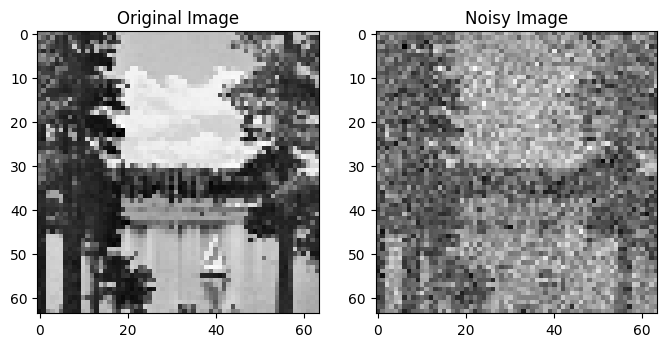

In [15]:
imname = "lake_gray"
image = imresize(testimage(imname), 64, 64)

image = Float64.(Gray.(image))

## Gaussian noise added
σ = 0.2
im_noisy = image .+ randn(size(image))*σ;

PyPlot.figure(figsize=(8,8))
PyPlot.subplot(1,2,1); PyPlot.imshow(image,cmap="gray"); PyPlot.title("Original Image")
PyPlot.subplot(1,2,2); PyPlot.imshow(im_noisy,cmap="gray"); PyPlot.title("Noisy Image");

### The underlying graph is 2D grid 
- Nodes are pixels. 
- Each node connected to its four direct neighbor.  

In [16]:
nx = size(image,1)
ny = size(image,2)
rs = (v) -> reshape(v,nx,ny)
image = image[:];
im_noisy = im_noisy[:];

G = LightGraphs.grid([nx,ny]);

### Denoising via graph Tikhonov regularization
- We solve this problem in two steps by using graph Tikhonov regularization: 
    1. Select the value of $\mu$ that gives the best de-noising performance
    2. Compute the solution by pluging the selected value 

#### Parameter Selection 

In [17]:
MU = collect(0.5:0.5:5.)
nrepsure = 10
# Parameter selection for the exact solution
mu_hat,scores_hat = SURE(G,im_noisy;σ=σ,mu_range=MU,nrep = nrepsure,method="exact");

# Parameter selection for the RSF estimates
mu_tilde,scores_tilde = SURE(G,im_noisy;σ=σ,mu_range=MU,nrep = nrepsure,method="xtilde");
mu_bar,scores_bar = SURE(G,im_noisy;σ=σ,mu_range=MU,nrep = nrepsure,method="xbar");


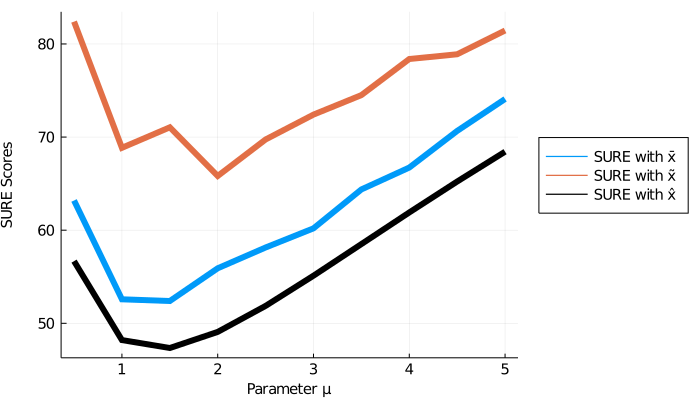

In [18]:
### SURE scores for the exact solution of graph TR and the RSF estimates
Plots.plot(MU, scores_bar, line=(:solid,6), label="SURE with x̄")
Plots.plot!(MU, scores_tilde, line=(:solid,6), label="SURE with x̃")
Plots.plot!(MU, scores_hat, line=(:solid,:black,6), label="SURE with x̂")

Plots.plot!(xlabel = "Parameter μ", ylabel = "SURE Scores\n  ")
Plots.plot!(size=[700,400],tickfont=10, guidefont=10,legend=:outerright,legendfont=10, xlims=[minimum(MU), maximum(MU)])

#### Computing the solution 

- After having the parameters selected for each method, we run the methods to compute the solutions

In [19]:
nrep = 40

xhat = smooth(G,mu_hat,im_noisy)
xhat = rs(xhat)

xtilde = smooth_rf(G,mu_tilde,im_noisy;variant=1,nrep=nrep).est
xtilde = rs(xtilde)

xbar = smooth_rf(G,mu_bar,im_noisy;variant=2,nrep=nrep).est
xbar = rs(xbar)

xtilde_1rep = smooth_rf(G,mu_tilde,im_noisy;variant=1,nrep=1).est
xtilde_1rep = rs(xtilde_1rep)

xbar_1rep = smooth_rf(G,mu_bar,im_noisy;variant=2,nrep=1).est
xbar_1rep = rs(xbar_1rep);


### Qualitative Results

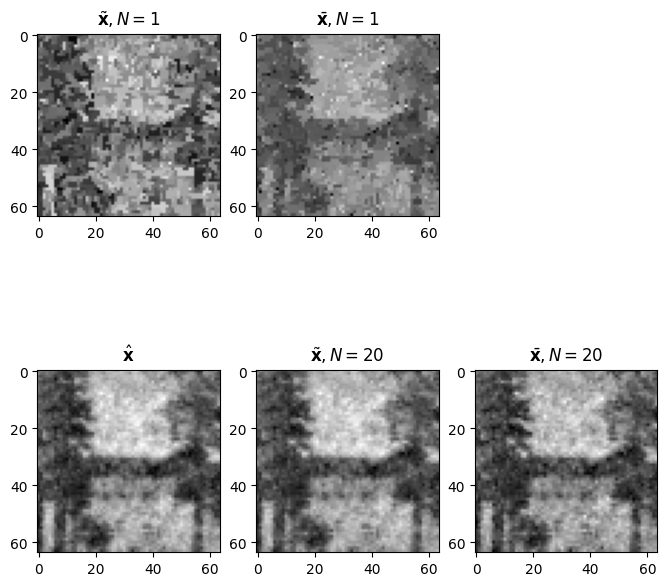

In [20]:
### Plot the results
PyPlot.figure(figsize=(8,8))
PyPlot.subplot(2,3,1); PyPlot.imshow(xtilde_1rep,cmap="gray"); PyPlot.title(L"\tilde{\mathbf{x}}, N = 1")
PyPlot.subplot(2,3,2); PyPlot.imshow(xbar_1rep,cmap="gray"); PyPlot.title(L"\bar{\mathbf{x}}, N = 1");
PyPlot.subplot(2,3,4); PyPlot.imshow(xhat,cmap="gray"); PyPlot.title(L"\hat{\mathbf{x}}")
PyPlot.subplot(2,3,5); PyPlot.imshow(xbar,cmap="gray"); PyPlot.title(L"\tilde{\mathbf{x}}, N = 20")
PyPlot.subplot(2,3,6); PyPlot.imshow(xtilde,cmap="gray"); PyPlot.title(L"\bar{\mathbf{x}}, N = 20");


### Quantitative Results

In [21]:
y = rs(im_noisy)
noisy_psnr = (ImageQualityIndexes.assess_psnr(y, image))
xhat_psnr = (ImageQualityIndexes.assess_psnr(xhat, image))
xtilde_psnr = (ImageQualityIndexes.assess_psnr(xtilde, image))
xbar_psnr = (ImageQualityIndexes.assess_psnr(xbar, image))

display("noisy image PSNR: $noisy_psnr")
display("xhat PSNR: $xhat_psnr")
display("xtilde PSNR : $xtilde_psnr")
display("xbar PSNR : $xbar_psnr")


"noisy image PSNR: 14.1076564045798"

"xhat PSNR: 19.260503974050696"

"xtilde PSNR : 18.741215958045302"

"xbar PSNR : 19.163943982725574"


## 2 - Poisson noise and graph-regularized maximum (log) likelihood estimation (Newton's method)

Assume that the noisy image $\mathbf{y}$ is generated by a Poisson model based on $\mathbf{x}$: 

$$ 
    \forall i,\quad y_i \propto \text{Poisson}(x_i) 
$$ 

To denoise this image, maximum likelihood estimation is adapted with graph-regularization as follows: 
$$
    \hat{\mathbf{x}} = \arg\min_{\mathbf{t}\in\mathbb{R}^n}-\mu \sum_{i=1}^n \log P({y}_i|\lambda=\exp({t}_i)) + \frac{1}{2}\mathbf{t}^\top\mathsf{L}\mathbf{t} 
$$

$$ 
\quad \text{ with } \quad P(y_i|\lambda = \exp(t_i)) = \frac{\exp(t_i)^{y_i}\exp(-\exp(t_i))}{y_i!}
$$
where $\mu>0$ is the regularization parameter and $P(y_i|\lambda = \exp(t_i))$ is the probability of having the noisy pixel $y_i$ for a fixed estimation $\exp(t_i)$. 

The gradient and Hessian of the objective function $L(\mathbf{t})$ are available, thus Newton's method is applicable:

$$
\nabla L(\mathbf{t}) =\mu\exp(\mathbf{t})-\mu\mathbf{y} + \mathsf{L}\mathbf{t}  \\
\mathsf{H}L(\mathbf{t}) = \mu\texttt{diag}(\exp(\mathbf{t}))  + \mathsf{L} 
$$

An updates of Newton's method read at iteration $k$ reads:

$$ 
\mathbf{t}_{k+1}= \mathbf{t}_k -\alpha \left[ \mu\texttt{diag}(\exp(\mathbf{t}_k))  + \mathsf{L}\right] ^{-1}(\mu\exp(\mathbf{t}_k)-\mu\mathbf{y} + \mathsf{L}\mathbf{t}_k)
$$

which can be approximated by the RSF estimators.

### Load the image

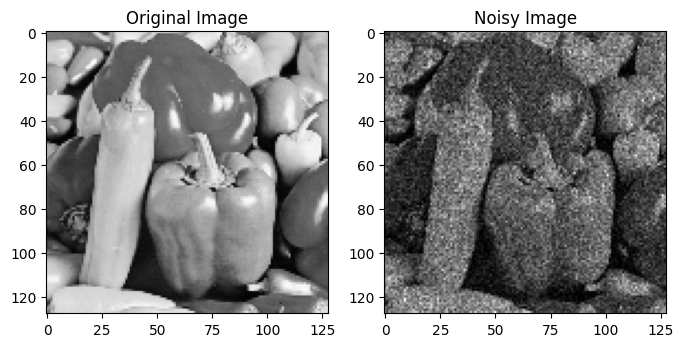

In [24]:
imname = "peppers"
image = Gray.(imresize(testimage(imname),128,128))

nx = size(image,1)
ny = size(image,2)
rs = (v) -> reshape(v,nx,ny)
G = LightGraphs.grid([nx,ny])
rescale = 25
scaledimage = Float64.(rescale .* image)
im_noisy = pois_rand.(scaledimage)

PyPlot.figure(figsize=(8,8))
PyPlot.subplot(1,2,1); PyPlot.imshow(Float64.(image),cmap="gray"); PyPlot.title("Original Image")
PyPlot.subplot(1,2,2); PyPlot.imshow(Float64.(im_noisy/rescale),cmap="gray"); PyPlot.title("Noisy Image");

### Run Newton's method

In [26]:
x = zeros(size(image))
xtilde = zeros(size(image))
xbar = zeros(size(image))
y = im_noisy[:]


z0 = (rand(nv(G)))
mu = 0.1
nrep = 40
maxiter = 100
tol = 10^(-10)
xhat,increment_hat,loss_hat = newton(G,y,z0,mu;numofiter = maxiter,tol=tol, method="exact")
xtilde,increment_tilde,loss_tilde = newton(G,y,z0,mu;numofiter = maxiter,tol=tol, method="xtilde",nrep=nrep)
xbar,increment_bar,loss_bar = newton(G,y,z0,mu;numofiter = maxiter,tol=tol, method="xbar",nrep=nrep);


Iteration=0, ||t_k - t_{k+1}||^2=73.57836502759169, alpha=0.1
Iteration=1, ||t_k - t_{k+1}||^2=206.37051015682064, alpha=0.25
Iteration=2, ||t_k - t_{k+1}||^2=37.860312997008585, alpha=0.5
Iteration=3, ||t_k - t_{k+1}||^2=11.610953028309268, alpha=0.5
Iteration=4, ||t_k - t_{k+1}||^2=5.07991185598464, alpha=0.5
Iteration=5, ||t_k - t_{k+1}||^2=2.3998392083054503, alpha=0.5
Iteration=6, ||t_k - t_{k+1}||^2=1.1686784614546222, alpha=0.5
Iteration=7, ||t_k - t_{k+1}||^2=0.5769448065227465, alpha=0.5
Iteration=8, ||t_k - t_{k+1}||^2=0.2866727473146827, alpha=0.5
Iteration=9, ||t_k - t_{k+1}||^2=0.14289240371310952, alpha=0.5
Iteration=10, ||t_k - t_{k+1}||^2=0.07133594188047127, alpha=0.5
Iteration=11, ||t_k - t_{k+1}||^2=0.035640496866731285, alpha=0.5
Iteration=12, ||t_k - t_{k+1}||^2=0.017813391240242192, alpha=0.5
Iteration=13, ||t_k - t_{k+1}||^2=0.008904982735020614, alpha=0.5
Iteration=14, ||t_k - t_{k+1}||^2=0.004452063322728062, alpha=0.5
Iteration=15, ||t_k - t_{k+1}||^2=0.002225

Iteration=27, ||t_k - t_{k+1}||^2=4.694232090490013e-10, alpha=6.103515625e-5
Iteration=28, ||t_k - t_{k+1}||^2=1.2971521334363622e-10, alpha=1.52587890625e-5
Method: xbar. Terminated after 29 iterations, increment 1.4678146054985358e-11


### Loss function through the iterations

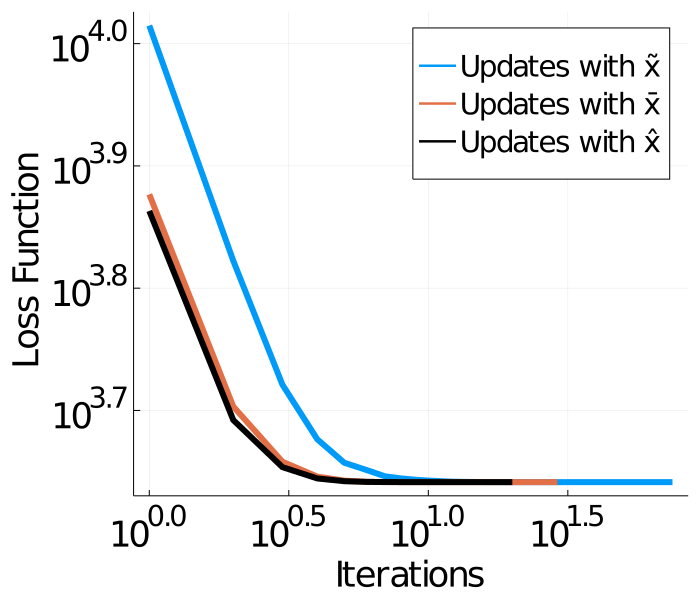

In [27]:
Plots.plot((1:length(loss_tilde)),(loss_tilde), line=(:solid,6), label="Updates with x̃")
Plots.plot!((1:length(loss_bar)),(loss_bar), line=(:solid,6), label="Updates with x̄")
Plots.plot!((1:length(loss_hat)),(loss_hat), line=(:solid,:black,6), label="Updates with x̂")

Plots.plot!(xlabel = "Iterations", ylabel = "Loss Function ", xaxis=:log,yaxis=:log)
Plots.plot!(size=[700,600],tickfont=24, guidefont=24,legend=true,legendfont=20)

### Qualitative Results

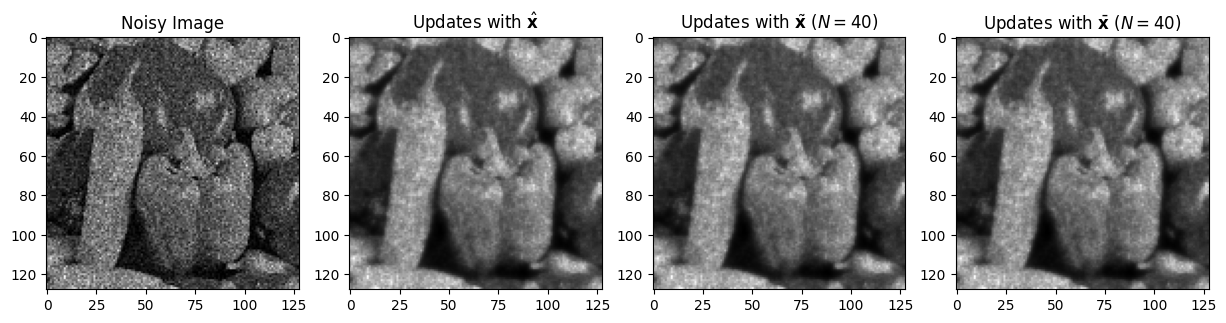

In [28]:
image = rs(image)
y = rs(y./rescale)
xhat = rs(xhat./rescale)
xtilde = rs(xtilde./rescale)
xbar = rs(xbar./rescale);
PyPlot.figure(figsize=(15,15))
PyPlot.subplot(1,4,1); PyPlot.imshow(y,cmap="gray"); PyPlot.title("Noisy Image")
PyPlot.subplot(1,4,2); PyPlot.imshow(xhat,cmap="gray"); PyPlot.title(L"Updates with $\hat{\mathbf{x}}$")
PyPlot.subplot(1,4,3); PyPlot.imshow(xtilde,cmap="gray"); PyPlot.title(L"Updates with $\tilde{\mathbf{x}}$ $(N = 40)$")
PyPlot.subplot(1,4,4); PyPlot.imshow(xbar,cmap="gray"); PyPlot.title(L"Updates with $\bar{\mathbf{x}}$ $(N = 40)$");

### Quantitative Results

In [29]:

display("Noisy image psnr: $(ImageQualityIndexes.assess_psnr(y, image))")
display("xhat psnr: $(ImageQualityIndexes.assess_psnr(xhat, image))")
display("xtilde psnr : $(ImageQualityIndexes.assess_psnr(xtilde, image))")
display("xbar psnr : $(ImageQualityIndexes.assess_psnr(xbar, image))")


"Noisy image psnr: 17.20381328465703"

"xhat psnr: 22.849856707846456"

"xtilde psnr : 22.849856730834386"

"xbar psnr : 22.849856720025702"